In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

model_path = 'ann_best.pth'

img_x_size = int(335)
img_y_size = int(218)
num_channels = 1
input_size = img_x_size * img_y_size * num_channels
dropout_p = 0.3

if not torch.backends.mps.is_available():
    device = torch.device('cpu')
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        fc1_in = input_size
        fc1_out = 1000
        self.fc1 = nn.Linear(fc1_in, fc1_out)
        # nn.init.normal_(self.fc1.weight, mean=0, std=1/math.sqrt(fc1_in))
        # nn.init.normal_(self.fc1.bias, mean=0, std=1)
        # self.dropout1 = nn.Dropout(p=dropout_p)

        self.bn1 = nn.BatchNorm1d(fc1_out) # Batch normalization for fc1
        # TODO: weight initialization for batchnorm layer?

        fc2_in = fc1_out
        fc2_out = 500
        self.fc2 = nn.Linear(fc2_in, fc2_out)
        # nn.init.normal_(self.fc2.weight, mean=0, std=1/math.sqrt(fc2_in))
        # nn.init.normal_(self.fc2.bias, mean=0, std=1)
        self.dropout2 = nn.Dropout(p=dropout_p)

        self.bn2 = nn.BatchNorm1d(fc2_out)   # Batch normalization for fc2

        fc3_in = fc2_out
        fc3_out = 100
        self.fc3 = nn.Linear(fc3_in, fc3_out)  # Output layer with 10 units for 10 genres
        # nn.init.normal_(self.fc3.weight, mean=0, std=1/math.sqrt(fc3_in))
        # nn.init.normal_(self.fc3.bias, mean=0, std=1)
        # self.dropout3 = nn.Dropout(p=dropout_p)
        
        self.bn3 = nn.BatchNorm1d(fc3_out)   # Batch normalization for fc2

        fc4_in = fc3_out
        fc4_out = 10
        self.fc4 = nn.Linear(fc4_in, fc4_out)  # Output layer with 10 units for 10 genres
        # nn.init.normal_(self.fc4.weight, mean=0, std=1/math.sqrt(fc4_in))
        # nn.init.normal_(self.fc4.bias, mean=0, std=1)

    def forward(self, x):
        x = x.view(-1, input_size)

        # Apply sigmoid activation at each layer
        x = self.fc1(x)
        x = self.bn1(x)  # Apply batch normalization to fc1
        x = F.relu(x)
        # x = self.dropout1(x)  # Apply dropout after the first layer
        
        x = self.fc2(x)
        x = self.bn2(x)  # Apply batch normalization to fc2
        x = F.relu(x)
        x = self.dropout2(x)  # Apply dropout after the second layer
        
        x = self.fc3(x)
        x = self.bn3(x)  # Apply batch normalization to fc3
        x = F.relu(x)
        # x = self.dropout3(x)  # Apply dropout after the second layer

        x = F.relu(self.fc4(x))

        # x = F.softmax(x, dim=1)

        return x

In [2]:
net = Net()

# Calculate the number of trainable parameters
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
total_params

73585810

In [3]:
from util import load_data_from_split
split_songs = False
train_loader, val_loader, test_loader = load_data_from_split(resize_images=False, batch_size=10, split_songs=split_songs)

/Users/steven/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [81]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from util import train_loop

net = Net()
num_epochs = 20
criterion = nn.CrossEntropyLoss() # loss function

optimizer = optim.SGD(net.parameters(), lr=5e-3, momentum=0, weight_decay=1e-5)

scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=(num_epochs/2)*len(train_loader), step_size_down=(num_epochs/2)*len(train_loader), mode='triangular')

training_losses, validation_losses = train_loop(
    net=net,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    model_path=model_path,
    split_songs=split_songs,
    num_epochs=num_epochs,
    optimizer=optimizer,
    scheduler=scheduler
)

Epoch 1 | LR: 0.00010 -> 0.00019 | Train Loss: 2.178 | Val Loss: 1.968 | Val Acc: 32.00%
Epoch 2 | LR: 0.00019 -> 0.00028 | Train Loss: 1.848 | Val Loss: 1.861 | Val Acc: 34.00%
Epoch 3 | LR: 0.00028 -> 0.00037 | Train Loss: 1.592 | Val Loss: 1.808 | Val Acc: 44.00%
Epoch 4 | LR: 0.00037 -> 0.00046 | Train Loss: 1.381 | Val Loss: 1.751 | Val Acc: 49.00%
Epoch 5 | LR: 0.00046 -> 0.00055 | Train Loss: 1.176 | Val Loss: 1.705 | Val Acc: 49.00%
Epoch 6 | LR: 0.00055 -> 0.00064 | Train Loss: 0.956 | Val Loss: 1.665 | Val Acc: 52.00%
Epoch 7 | LR: 0.00064 -> 0.00073 | Train Loss: 0.723 | Val Loss: 1.637 | Val Acc: 50.00%
Epoch 8 | LR: 0.00073 -> 0.00082 | Train Loss: 0.573 | Val Loss: 1.576 | Val Acc: 49.00%
Epoch 9 | LR: 0.00082 -> 0.00091 | Train Loss: 0.439 | Val Loss: 1.555 | Val Acc: 50.00%
Epoch 10 | LR: 0.00091 -> 0.00100 | Train Loss: 0.373 | Val Loss: 1.554 | Val Acc: 50.00%
Epoch 11 | LR: 0.00100 -> 0.00091 | Train Loss: 0.310 | Val Loss: 1.540 | Val Acc: 50.00%
Epoch 12 | LR: 0.00

In [83]:
from util import test_model, test_model_aggregate

net = Net()
net.to(device)

# Load the best saved model weights
net.load_state_dict(torch.load(f"models/{model_path}"))

test_accuracy, test_loss = test_model(net, test_loader, device, criterion)

results_str = f"Test Accuracy | Idv: {test_accuracy:.2f}%"
if(split_songs):
    test_accuracy_agg = test_model_aggregate(net, test_loader, device)
    results_str += f", Agg: {test_accuracy_agg:.2f}%"

print(results_str)

Test Accuracy | Idv: 51.00%


[2.1776107996702194, 1.848007820546627, 1.5917977705597877, 1.380607570707798, 1.1760029457509518, 0.9559479869902134, 0.723469116166234, 0.573155352845788, 0.4388303326442838, 0.3727551707997918, 0.3104449223726988, 0.3021510051563382, 0.2257928928360343, 0.1864972621202469, 0.17957747234031557, 0.15733995707705617, 0.1623209336772561, 0.15098564508371054, 0.12175698657520115, 0.13727872404269875] [1.9678052067756653, 1.8605483531951905, 1.8079592823982238, 1.7508163094520568, 1.7045459985733031, 1.665364956855774, 1.6366252779960633, 1.575569486618042, 1.5547997593879699, 1.5540575742721559, 1.5402992129325868, 1.527490383386612, 1.4793010920286178, 1.5011501073837281, 1.5249832391738891, 1.4631983876228332, 1.4856610894203186, 1.5110902070999146, 1.4786349892616273, 1.4942681670188904]


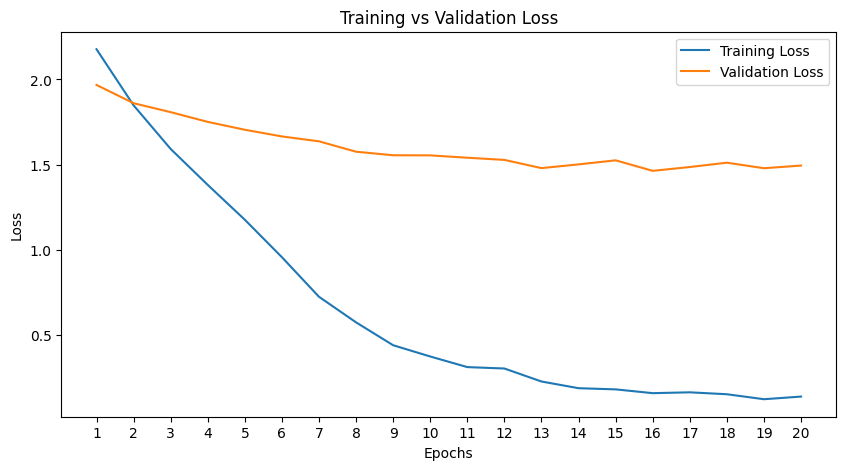

In [84]:
from util import plot_loss
print(training_losses, validation_losses)
plot_loss(training_losses, validation_losses)